## How much money can a director lose before they disappear in the industry?

### How many box office bombs can an established director endure?

In [114]:
# 20200726 JLCY
# data from https://www.the-numbers.com/

import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

xl = pd.ExcelFile('directors_data.xlsx')
print('number of directors:', len(xl.sheet_names))

eliminate_yr_threshold = 2016

pd.options.mode.chained_assignment = None

number of directors: 50


In [115]:
if os.path.exists('single_df.csv'): 
    
    combine_df = pd.read_csv('single_df.csv')
    
else: 
    
    append_data = []

    for sheet_name in xl.sheet_names: 

        #print(sheet_name)

        xl_file = pd.read_excel('directors_data.xlsx', sheet_name=sheet_name)

        # combine 1st 2 rows as column names
        combine_col = []

        for ind, col in enumerate(xl_file.columns): 

            if isinstance(xl_file.iloc[0, ind], str): 
                combine_col.append(col + ' ' + xl_file.iloc[0, ind])
            else: 
                combine_col.append(col)

        combine_col = ['Opening Theaters' if i == 'Opening.1 Theaters' else i for i in combine_col]

        xl_file.columns = combine_col

        df = xl_file.iloc[1:-3] # drop 1st row and last 3 summary rows
        df.reset_index(inplace=True)
        df = df.iloc[:, 1:] # drop 1st duplicating column

        # populate data for multiple roles in the same movie
        nan_col = [col for col in df.columns if col not in ['Role']]

        for i in df.index: 

            if type(df['Title'][i]) is float: 

                if math.isnan(df['Title'][i]) and isinstance(df['Role'][i], str): 

                    for col in nan_col: 
                        df[col][i] = df[col][i-1] # set data to the row above

        df['Director'] = sheet_name
        
        df['Release Date'] = pd.to_datetime(df['Release Date'])

        if df['Release Date'].dt.year.unique().max() < eliminate_yr_threshold: 
            df['Stopped Making Movies'] = True
        else: 
            df['Stopped Making Movies'] = False
            
        df['Personal Role Count'] = (np.arange(len(df))+1)[::-1]
        
        df['Personal Director Count'] = np.NaN
        df.loc[df['Role'] == 'Director', 'Personal Director Count'] \
            = (np.arange(len(df.loc[df['Role'] == 'Director']))+1)[::-1]
        
        df['Personal Movie count'] = np.NaN
        df['Personal Movie count'].iloc[-1] = 1
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                df['Personal Movie count'][i] = df['Personal Movie count'][i+1] + 1
            else: 
                df['Personal Movie count'][i] = df['Personal Movie count'][i+1]
        
        df['Profit'] = df['Worldwide Box Office'] - df['Production Budget']
        df.loc[:, 'Profit'] = df['Profit'].astype(float)

        df['Cumulated Profit'] = np.NaN
        df['Cumulated Profit'].iloc[-1] = df['Profit'].iloc[-1]
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                df['Cumulated Profit'][i] = np.nansum([df['Cumulated Profit'][i+1], df['Profit'][i]])
            else: 
                df['Cumulated Profit'][i] = df['Cumulated Profit'][i+1]
                
        df['Profitable Movie Count'] = 0
        df['Unprofitable Movie Count'] = 0
        df['Unknown profit Movie Count'] = 0
        
        if math.isnan(df['Profit'].iloc[-1]): # bottom row
            df['Unknown profit Movie Count'].iloc[-1] += 1
        else: 
            if df['Profit'].iloc[-1] > 0: 
                df['Profitable Movie Count'].iloc[-1] += 1
            else: 
                df['Unprofitable Movie Count'].iloc[-1] += 1
                
        for i in reversed(df.index[:-1]): 
            if df['Title'][i] != df['Title'][i+1]: 
                if math.isnan(df['Profit'][i]): 
                    df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1:].max() + 1
                else: 
                    if df['Profit'][i] > 0: 
                        df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1:].max() + 1
                    else: 
                        df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1:].max() + 1
            else: 
                df['Profitable Movie Count'][i] = df['Profitable Movie Count'][i+1]
                df['Unprofitable Movie Count'][i] = df['Unprofitable Movie Count'][i+1]
                df['Unknown profit Movie Count'][i] = df['Unknown profit Movie Count'][i+1]
        
        df['Profitable Movie Director Count'] = 0
        df['Unprofitable Movie Director Count'] = 0
        df['Unknown profit Movie Director Count'] = 0
        
        df.loc[(df['Role'] == 'Director') & (df['Profit'] > 0), 'Profitable Movie Director Count'] \
            = (np.arange(len(df.loc[(df['Role'] == 'Director') & (df['Profit'] > 0)]))+1)[::-1]
        df.loc[(df['Role'] == 'Director') & (df['Profit'] < 0), 'Unprofitable Movie Director Count'] \
            = (np.arange(len(df.loc[(df['Role'] == 'Director') & (df['Profit'] < 0)]))+1)[::-1]
        df.loc[(df['Role'] == 'Director') & (df['Profit'].isnull()), 'Unknown profit Movie Director Count'] \
            = (np.arange(len(df.loc[(df['Role'] == 'Director') & (df['Profit'].isnull())]))+1)[::-1]

        append_data.append(df)

    combine_df = pd.concat(append_data)
    
    combine_df.to_csv('single_df.csv')
    
combine_df['Release Date'] = pd.to_datetime(combine_df['Release Date'])

combine_df.loc[combine_df['Profitable Movie Director Count'] == 0, 'Profitable Movie Director Count'] = np.NaN
combine_df.loc[combine_df['Unprofitable Movie Director Count'] == 0, 'Unprofitable Movie Director Count'] = np.NaN

In [116]:
combine_df

,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,Theatrical Engagements,...,Personal Director Count,Personal Movie count,Profit,Cumulated Profit,Profitable Movie Count,Unprofitable Movie Count,Unknown profit Movie Count,Profitable Movie Director Count,Unprofitable Movie Director Count,Unknown profit Movie Director Count
0,2021-06-04,Micronauts,Producer,Paramount Pictures,Adventure,NaN,NaN,NaN,NaN,NaN,...,NaN,18.0,NaN,6.063242e+09,0,0,3,NaN,NaN,0
1,2019-12-20,Star Wars: The Rise of Skyw…,Director,Walt Disney,Adventure,275000000,177383864,4406,4406,29704,...,6.0,17.0,798469600.0,6.063242e+09,15,0,0,6.0,NaN,0
2,2019-12-20,Star Wars: The Rise of Skyw…,Screenwriter,Walt Disney,Adventure,275000000,177383864,4406,4406,29704,...,NaN,17.0,798469600.0,6.063242e+09,15,0,0,NaN,NaN,0
3,2019-12-20,Star Wars: The Rise of Skyw…,Producer,Walt Disney,Adventure,275000000,177383864,4406,4406,29704,...,NaN,17.0,798469600.0,6.063242e+09,15,0,0,NaN,NaN,0
4,2018-11-09,Overlord,Producer,Paramount Pictures,Action,38000000,10202108,2859,2859,8038,...,NaN,16.0,1178189.0,5.264773e+09,14,0,0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,2008-08-29,Disaster Movie,Director,Lionsgate,Comedy,20000000,5836973,2642,2642,8771,...,4.0,5.0,16720752.0,4.615723e+08,5,0,0,4.0,NaN,0
11,2008-01-25,Meet the Spartans,Director,20th Century Fox,Comedy,30000000,18505530,2605,2643,10672,...,3.0,4.0,54646831.0,4.448516e+08,4,0,0,3.0,NaN,0
12,2007-01-26,Epic Movie,Director,20th Century Fox,Comedy,20000000,18612544,2801,2840,11371,...,2.0,3.0,66858578.0,3.902047e+08,3,0,0,2.0,NaN,0
13,2006-02-17,Date Movie,Director,20th Century Fox,Comedy,20000000,19076261,2896,2898,13117,...,1.0,2.0,65146165.0,3.233462e+08,2,0,0,1.0,NaN,0


In [86]:
df.columns

Index(['Unnamed: 0', 'Release Date', 'Title', 'Role', 'Distributor', 'Genre',
       'Production Budget', 'Opening Weekend', 'Opening Theaters',
       'Maximum Theaters', 'Theatrical Engagements', 'Domestic Box Office',
       'International Box Office', 'Worldwide Box Office', 'Unnamed: 13',
       'Person', 'Stopped Making Movies', 'Personal Role Count',
       'Personal Director Count', 'Personal Movie count', 'Profit',
       'Cumulated Profit', 'Profitable Movie Count',
       'Unprofitable Movie Count', 'Unknown profit Movie Count',
       'Profitable Movie Director Count', 'Unprofitable Movie Director Count',
       'Unknown profit Movie Director Count'],
      dtype='object')

In [117]:
df = combine_df.loc[combine_df['Release Date'].dt.year < 2020] # 2020 is an outlier...

df = df.loc[df['Profit'].notnull()] # over 150 rows have incomplete information... 

df = df.loc[df['Role'] == 'Director']
print('did not direct a movie:', set(combine_df['Director'].unique()) - set(df['Director'].unique()))

quit_df = df.loc[df['Stopped Making Movies'] == True]
quit_df = quit_df.loc[quit_df['Director'] != 'Joss Whedon']

stay_df = df.loc[df['Stopped Making Movies'] == False]

compare_df = df.loc[(df['Director'] == 'Martin Scorsese') | (df['Director'] =='Renny Harlin') 
                    | (df['Director'] == 'Woody Allen') | (df['Director'] == 'Ron Howard') 
                    | (df['Director'] == 'Ang Lee')]

did not direct a movie: {'Edgar Rice Burroughs'}


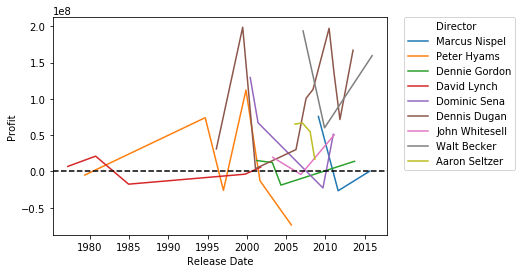

In [118]:
sns.lineplot(x='Release Date', y='Profit', hue='Director', data=quit_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0, c='k', linestyle='--')

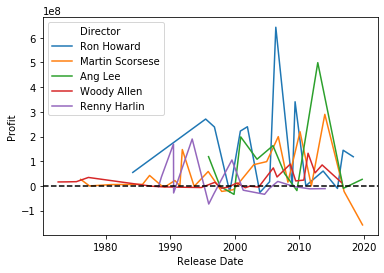

In [119]:
sns.lineplot(x='Release Date', y='Profit', hue='Director', data=compare_df)
plt.axhline(0, c='k', linestyle='--')

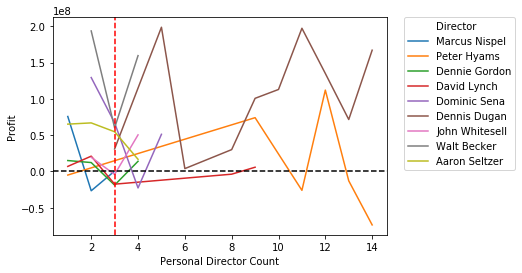

In [120]:
sns.lineplot(x='Personal Director Count', y='Profit', hue='Director', data=quit_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0, c='k', linestyle='--')
plt.axvline(3, c='r', linestyle='--')

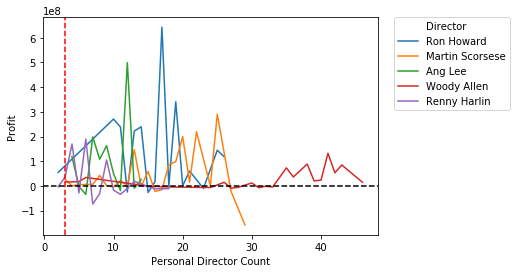

In [121]:
sns.lineplot(x='Personal Director Count', y='Profit', hue='Director', data=compare_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(0, c='k', linestyle='--')
plt.axvline(3, c='r', linestyle='--')

In [129]:
compare_df.loc[(compare_df['Profit'] < 0) & (compare_df['Personal Director Count'] <= 3)]['Director']

22    Renny Harlin
Name: Director, dtype: object

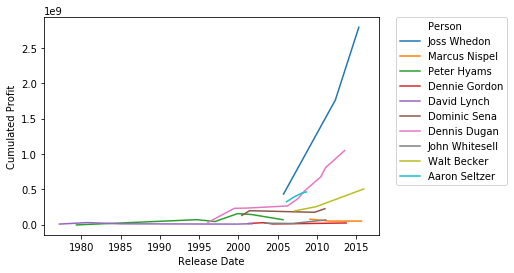

In [57]:
sns.lineplot(x='Release Date', y='Cumulated Profit', hue='Director', data=quit_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

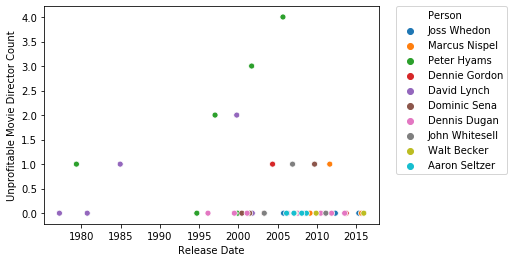

In [61]:
sns.scatterplot(x='Release Date', y='Unprofitable Movie Director Count', hue='Director', data=quit_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [130]:
quit_df.groupby('Director')['Unprofitable Movie Director Count'].max()

Director
Aaron Seltzer     NaN
David Lynch       2.0
Dennie Gordon     1.0
Dennis Dugan      NaN
Dominic Sena      1.0
John Whitesell    1.0
Marcus Nispel     1.0
Peter Hyams       4.0
Walt Becker       NaN
Name: Unprofitable Movie Director Count, dtype: float64

In [131]:
stay_df.groupby('Director')['Unprofitable Movie Director Count'].max()

Director
Ang Lee                 4.0
Ava Duvernay            NaN
Ben Affleck             1.0
Brian Levant            NaN
Brian Robbins           3.0
Denis Villeneuve        NaN
Frank Coraci            1.0
Garry Marshall          1.0
George Lucas            NaN
J.J. Abrams             NaN
James Cameron           1.0
Joe Russo               NaN
Jon Favreau             1.0
Jonathan Liebesman      NaN
Kevin Costner           1.0
Lana Wachowski          1.0
M. Night Shyamalan      1.0
Mark Steven Johnson     1.0
Martin Scorsese         7.0
Michael Bay             NaN
Peter Berg              2.0
Peter Chelsom           2.0
Peter Jackson           2.0
Quentin Tarantino       NaN
Raja Gosnell            NaN
Renny Harlin           10.0
Ridley Scott            3.0
Roger Kumble            NaN
Roland Joffe            3.0
Ron Howard              4.0
Stephen Gaghan          NaN
Steven Brill            NaN
Steven Spielberg        NaN
Tim Burton              1.0
Timur Bekmambetov       1.0
Tom Hooper 

In [54]:
print(quit_df['Director'].unique())
print(len(quit_df['Director'].unique()))

['Joss Whedon' 'Marcus Nispel' 'Peter Hyams' 'Dennie Gordon' 'David Lynch'
 'Dominic Sena' 'Dennis Dugan' 'John Whitesell' 'Walt Becker'
 'Aaron Seltzer']
10


In [34]:
df.drop('Stopped Making Movies',axis=1)

,Unnamed: 0,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,...,Personal Director Count,Personal Movie count,Profit,Cumulated Profit,Profitable Movie Count,Unprofitable Movie Count,Unknown profit Movie Count,Profitable Movie Director Count,Unprofitable Movie Director Count,Unknown profit Movie Director Count
1,1,2019-12-20,Star Wars: The Rise of Skyw…,Director,Walt Disney,Adventure,275000000.0,177383864.0,4406.0,4406.0,...,6.0,17.0,7.984696e+08,6.063242e+09,15,0,0,6,0,0
8,8,2015-12-18,Star Wars Ep. VII: The Forc…,Director,Walt Disney,Adventure,306000000.0,247966675.0,4134.0,4134.0,...,5.0,12.0,1.759478e+09,4.410329e+09,10,0,0,5,0,0
13,13,2013-05-16,Star Trek Into Darkness,Director,Paramount Pictures,Adventure,190000000.0,70165559.0,3868.0,3907.0,...,4.0,9.0,2.773816e+08,2.111992e+09,8,0,0,4,0,0
18,18,2011-06-10,Super 8,Director,Paramount Pictures,Thriller/Suspense,50000000.0,35451168.0,3379.0,3424.0,...,3.0,7.0,2.079727e+08,1.284897e+09,6,0,0,3,0,0
20,20,2009-05-08,Star Trek,Director,Paramount Pictures,Adventure,140000000.0,79204289.0,3849.0,4053.0,...,2.0,5.0,2.468396e+08,1.057130e+09,4,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,3,2007-03-02,Wild Hogs,Director,Walt Disney,Comedy,60000000.0,39699023.0,3287.0,3401.0,...,2.0,2.0,1.935554e+08,1.935554e+08,1,0,0,1,0,0
1153,10,2008-08-29,Disaster Movie,Director,Lionsgate,Comedy,20000000.0,5836973.0,2642.0,2642.0,...,4.0,5.0,1.672075e+07,4.615723e+08,5,0,0,4,0,0
1154,11,2008-01-25,Meet the Spartans,Director,20th Century Fox,Comedy,30000000.0,18505530.0,2605.0,2643.0,...,3.0,4.0,5.464683e+07,4.448516e+08,4,0,0,3,0,0
1155,12,2007-01-26,Epic Movie,Director,20th Century Fox,Comedy,20000000.0,18612544.0,2801.0,2840.0,...,2.0,3.0,6.685858e+07,3.902047e+08,3,0,0,2,0,0


## sklearn practice

In [41]:
features = df[['Personal Role Count',
       'Personal Director Count', 'Personal Movie count', 'Profit',
       'Cumulated Profit', 'Profitable Movie Count',
       'Unprofitable Movie Count', 'Unknown profit Movie Count',
       'Profitable Movie Director Count', 'Unprofitable Movie Director Count',
       'Unknown profit Movie Director Count']]
labels = df[['Stopped Making Movies']]

rf = RandomForestClassifier()

scores = cross_val_score(rf, features, labels.values.ravel(), cv=5)
print(scores)

[0.88461538 0.84415584 0.8961039  0.83116883 0.85714286]


In [42]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
parameters = {
    'n_estimators': [5, 10, 20],
    'max_depth': [2, 10, 20, None]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(features, labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 2, 'n_estimators': 5}

0.883 (+/-0.001) for {'max_depth': 2, 'n_estimators': 5}
0.883 (+/-0.001) for {'max_depth': 2, 'n_estimators': 10}
0.883 (+/-0.001) for {'max_depth': 2, 'n_estimators': 20}
0.852 (+/-0.059) for {'max_depth': 10, 'n_estimators': 5}
0.863 (+/-0.027) for {'max_depth': 10, 'n_estimators': 10}
0.86 (+/-0.051) for {'max_depth': 10, 'n_estimators': 20}
0.857 (+/-0.058) for {'max_depth': 20, 'n_estimators': 5}
0.865 (+/-0.043) for {'max_depth': 20, 'n_estimators': 10}
0.868 (+/-0.042) for {'max_depth': 20, 'n_estimators': 20}
0.85 (+/-0.049) for {'max_depth': None, 'n_estimators': 5}
0.863 (+/-0.054) for {'max_depth': None, 'n_estimators': 10}
0.86 (+/-0.06) for {'max_depth': None, 'n_estimators': 20}


In [44]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

rf = RandomForestClassifier(n_estimators=5)
rf.fit(x_train, y_train.values.ravel())

print(rf.score(x_test, y_test))

0.8589743589743589


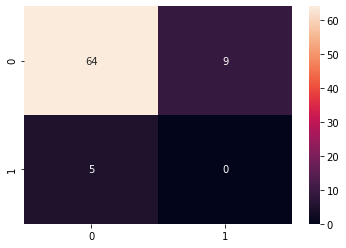

In [33]:
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)

In [45]:
# x = df.drop('Stopped Making Movies',axis=1)
# y = df['Stopped Making Movies']
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

In [46]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
mlp.fit(x_train, y_train)

/Users/jlee/opt/anaconda3/envs/moneyball/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jlee/opt/anaconda3/envs/moneyball/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [48]:
predictions = mlp.predict(x_test)
print(confusion_matrix(y_test,predictions))

[[73  0]
 [ 4  1]]


In [52]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

       False       0.95      1.00      0.97        73
        True       1.00      0.20      0.33         5

    accuracy                           0.95        78
   macro avg       0.97      0.60      0.65        78
weighted avg       0.95      0.95      0.93        78



In [138]:
stay_df

,Unnamed: 0,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,Theatrical Engagements,Domestic Box Office,International Box Office,Worldwide Box Office,Person,Stopped making movies,Personal movie count,Personal director count,Profit
1,1,2019-12-20,Star Wars: The Rise of Skyw…,Director,Walt Disney,Adventure,275000000.0,177383864.0,4406.0,4406.0,29704.0,515202542.0,5.582671e+08,1.073470e+09,J.J. Abrams,False,26,6.0,7.984696e+08
8,8,2015-12-18,Star Wars Ep. VII: The Forc…,Director,Walt Disney,Adventure,306000000.0,247966675.0,4134.0,4134.0,37852.0,936662225.0,1.128816e+09,2.065478e+09,J.J. Abrams,False,19,5.0,1.759478e+09
13,13,2013-05-16,Star Trek Into Darkness,Director,Paramount Pictures,Adventure,190000000.0,70165559.0,3868.0,3907.0,22815.0,228778661.0,2.386029e+08,4.673816e+08,J.J. Abrams,False,14,4.0,2.773816e+08
18,18,2011-06-10,Super 8,Director,Paramount Pictures,Thriller/Suspense,50000000.0,35451168.0,3379.0,3424.0,19362.0,127004179.0,1.309686e+08,2.579727e+08,J.J. Abrams,False,9,3.0,2.079727e+08
20,20,2009-05-08,Star Trek,Director,Paramount Pictures,Adventure,140000000.0,79204289.0,3849.0,4053.0,30077.0,257730019.0,1.291096e+08,3.868396e+08,J.J. Abrams,False,7,2.0,2.468396e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,4,2002-01-18,Snow Dogs,Director,Walt Disney,Adventure,32000000.0,17814259.0,2302.0,2454.0,20301.0,81150692.0,3.574734e+07,1.168980e+08,Brian Levant,False,5,5.0,8.489803e+07
1134,5,2000-04-28,The Flintstones in Viva Roc…,Director,Universal,Adventure,58000000.0,10518435.0,3040.0,3125.0,18444.0,35231365.0,2.420000e+07,5.943136e+07,Brian Levant,False,4,4.0,1.431365e+06
1135,6,1996-11-22,Jingle All the Way,Director,20th Century Fox,Adventure,60000000.0,12112267.0,2401.0,2404.0,18205.0,60592389.0,6.924000e+07,1.298324e+08,Brian Levant,False,3,3.0,6.983239e+07
1136,7,1994-05-27,The Flintstones,Director,Universal,Comedy,45000000.0,37182745.0,2498.0,2587.0,18296.0,130531208.0,2.279688e+08,3.585000e+08,Brian Levant,False,2,2.0,3.135000e+08


In [103]:
df

,Unnamed: 0,Release Date,Title,Role,Distributor,Genre,Production Budget,Opening Weekend,Opening Theaters,Maximum Theaters,Theatrical Engagements,Domestic Box Office,International Box Office,Worldwide Box Office,Person,Stopped making movies,Personal movie count,Personal director count,Profit
1,1,2019-12-20,Star Wars: The Rise of Skyw…,Director,Walt Disney,Adventure,275000000.0,177383864.0,4406.0,4406.0,29704.0,515202542.0,5.582671e+08,1.073470e+09,J.J. Abrams,False,26,6.0,7.984696e+08
8,8,2015-12-18,Star Wars Ep. VII: The Forc…,Director,Walt Disney,Adventure,306000000.0,247966675.0,4134.0,4134.0,37852.0,936662225.0,1.128816e+09,2.065478e+09,J.J. Abrams,False,19,5.0,1.759478e+09
13,13,2013-05-16,Star Trek Into Darkness,Director,Paramount Pictures,Adventure,190000000.0,70165559.0,3868.0,3907.0,22815.0,228778661.0,2.386029e+08,4.673816e+08,J.J. Abrams,False,14,4.0,2.773816e+08
18,18,2011-06-10,Super 8,Director,Paramount Pictures,Thriller/Suspense,50000000.0,35451168.0,3379.0,3424.0,19362.0,127004179.0,1.309686e+08,2.579727e+08,J.J. Abrams,False,9,3.0,2.079727e+08
20,20,2009-05-08,Star Trek,Director,Paramount Pictures,Adventure,140000000.0,79204289.0,3849.0,4053.0,30077.0,257730019.0,1.291096e+08,3.868396e+08,J.J. Abrams,False,7,2.0,2.468396e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,4,2013-11-15,The Starving Games,Director,Ketchup Entertainment,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,1.766150e+05,1.766150e+05,Aaron Seltzer,True,11,5.0,NaN
1153,10,2008-08-29,Disaster Movie,Director,Lionsgate,Comedy,20000000.0,5836973.0,2642.0,2642.0,8771.0,14190901.0,2.252985e+07,3.672075e+07,Aaron Seltzer,True,5,4.0,1.672075e+07
1154,11,2008-01-25,Meet the Spartans,Director,20th Century Fox,Comedy,30000000.0,18505530.0,2605.0,2643.0,10672.0,38233676.0,4.641316e+07,8.464683e+07,Aaron Seltzer,True,4,3.0,5.464683e+07
1155,12,2007-01-26,Epic Movie,Director,20th Century Fox,Comedy,20000000.0,18612544.0,2801.0,2840.0,11371.0,39739367.0,4.711921e+07,8.685858e+07,Aaron Seltzer,True,3,2.0,6.685858e+07


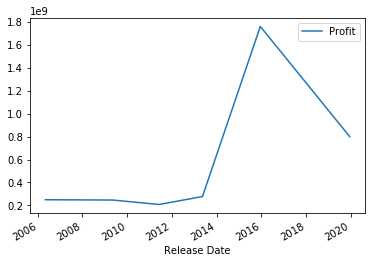

In [5]:
df.loc[df['Director'] == 'J.J. Abrams'].plot(x='Release Date', y='Profit')

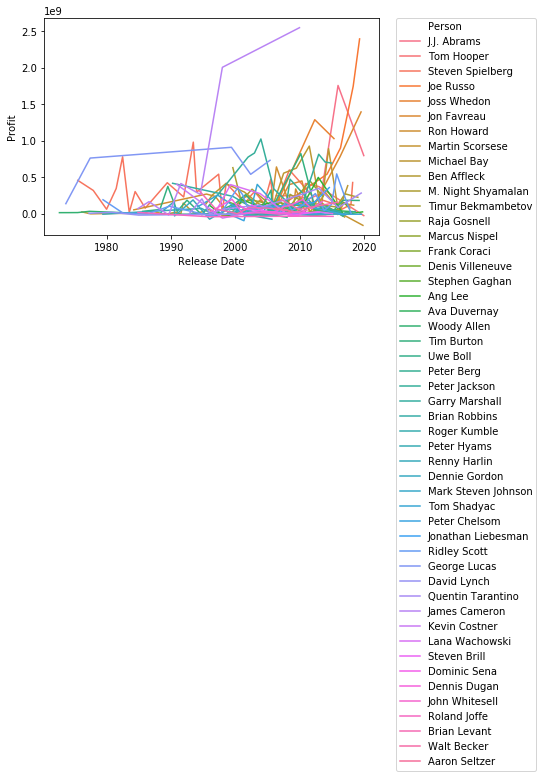

In [6]:
sns.lineplot(x='Release Date', y='Profit', hue='Director', data=df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)